### 가이드북

#### 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [ ]:
data = pd.read_csv('InjectionMolding_Raw_Data.csv')

#### 데이터 확인

In [ ]:
data.columns

Index(['No_Shot', 'Machine_Cycle_Time', 'Cycle_Time', 'Barrel_Temp_Z1',
       'Barrel_Temp_Z2', 'Barrel_Temp_Z3', 'Barrel_Temp_Z4', 'Hopper_Temp',
       'Injection_Pressure_Real_Time', 'Screw_Position',
       'Injection_Peak_Press', 'Max_Injection_Rate', 'Screw_Velocity',
       'VP_Time', 'VP_Position', 'Weighing_Start_Position', 'VP_Press',
       'Plasticizing_Time', 'Plasticizing_Start_Position',
       'Plasticizing_End_Position', 'Plasticizing_RPM', 'Minimum_Cushion',
       'Cooling_Time', 'Back_Flow', 'Decompression_Time', '_ID'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030635 entries, 0 to 1030634
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   No_Shot                       1030635 non-null  int64  
 1   Machine_Cycle_Time            1030635 non-null  float64
 2   Cycle_Time                    1030635 non-null  float64
 3   Barrel_Temp_Z1                1030635 non-null  float64
 4   Barrel_Temp_Z2                1030635 non-null  float64
 5   Barrel_Temp_Z3                1030635 non-null  float64
 6   Barrel_Temp_Z4                1030635 non-null  float64
 7   Hopper_Temp                   1030635 non-null  float64
 8   Injection_Pressure_Real_Time  1030635 non-null  float64
 9   Screw_Position                1030635 non-null  float64
 10  Injection_Peak_Press          1030635 non-null  float64
 11  Max_Injection_Rate            1030635 non-null  float64
 12  Screw_Velocity              

In [ ]:
data.count()

No_Shot                         1030635
Machine_Cycle_Time              1030635
Cycle_Time                      1030635
Barrel_Temp_Z1                  1030635
Barrel_Temp_Z2                  1030635
Barrel_Temp_Z3                  1030635
Barrel_Temp_Z4                  1030635
Hopper_Temp                     1030635
Injection_Pressure_Real_Time    1030635
Screw_Position                  1030635
Injection_Peak_Press            1030635
Max_Injection_Rate              1030635
Screw_Velocity                  1030635
VP_Time                         1030635
VP_Position                     1030635
Weighing_Start_Position         1030635
VP_Press                        1030635
Plasticizing_Time               1030635
Plasticizing_Start_Position     1030635
Plasticizing_End_Position       1030635
Plasticizing_RPM                1030635
Minimum_Cushion                 1030635
Cooling_Time                    1030635
Back_Flow                       1030635
Decompression_Time              1030635


#### 데이터 전처리

결측치 처리

In [ ]:
# 결측치 처리
print('결측치 개수:',data[data.isnull()==True].count().sum())

결측치 개수: 0


분석에 사용하지 않는 변수 제거

In [ ]:
# 분석에 사용하지 않는 변수 제거
data_drop=data.copy().drop(['Minimum_Cushion','Weighing_Start_Position','_ID'],axis=1)

Lot 단위 데이터 정리

In [ ]:
# Lot 단위 데이터 정리

# Lot별 분리함수
# Lot을 판단할 수 있는 공정변수 'No_Shot'을 기준으로 분리하여 리스트에 저장
def to_lot(data):

    lot_list = [0,data.shape[0]]
    for i in range(data.shape[0]):
        if data['No_Shot'][i] == 0:
            lot_list.append(i)
    lot_list.sort()
    data_lot = []

    for i in range(len(lot_list)-1):
        data_lot.append(data.iloc[lot_list[i]:lot_list[i+1]])

    return data_lot

In [ ]:
data_lot = to_lot(data_drop)

1. Lot의 정의

Lot는 특정한 기준에 따라 구분된 제품 또는 재료의 묶음을 의미합니다. 예를 들어, 한 번의 생산 또는 구매에 따라 생산된 제품 묶음이 하나의 Lot이 될 수 있습니다.

<br/>

2. Lot 단위 데이터
Lot 단위 데이터는 각 Lot에 대해 수집된 데이터를 의미합니다. 이 데이터는 생산 날짜, 생산 라인, 재료 배치, 품질 검사 결과, 수율 등 다양한 정보를 포함할 수 있습니다.

<br/>

3. Lot 단위 데이터 정리
Lot 단위 데이터 정리는 Lot 단위로 데이터를 체계적으로 수집, 저장, 분석, 그리고 보고하는 작업을 의미합니다. 이는 품질 관리, 생산 추적성, 문제 해결 및 개선을 위해 중요합니다.

수집: 각 Lot에 대해 필요한 데이터를 수집합니다.

저장: 수집된 데이터를 체계적으로 저장합니다.

분석: Lot 단위로 데이터를 분석하여 품질 및 생산 문제를 식별합니다.

보고: 분석 결과를 바탕으로 보고서를 작성하여 필요한 조치를 취합니다.

<br/>

 Lot 단위 데이터 정리는 데이터의 체계적인 관리를 통해 품질 및 생산 효율성을 높이는 데 중요한 역할을 합니다.

In [ ]:
# 데이터 갯수가 100 미만인 Lot 제거 함수

def error_drop(data_lot):

    normal_lot = []

    for i in range(len(data_lot)):
        if data_lot[i].shape[0]>=100:
            normal_lot.append(data_lot[i])

    return normal_lot

‘No_Shot’ 번호를 기준으로 Lot을 분리한다. ‘No_Shot’이 0이 되는 지점을 나눠서 Lot
별로 분리된 데이터가 저장되어있는 리스트 변수를 반환하는 ‘to_lot’ 함수를 ‘def’ 기능
을 통해 정의한다. 이후 data_lot 리스트 변수에 ‘to_lot’ 함수를 적용하여 저장한다.

In [ ]:
data_lot

[Empty DataFrame
 Columns: [No_Shot, Machine_Cycle_Time, Cycle_Time, Barrel_Temp_Z1, Barrel_Temp_Z2, Barrel_Temp_Z3, Barrel_Temp_Z4, Hopper_Temp, Injection_Pressure_Real_Time, Screw_Position, Injection_Peak_Press, Max_Injection_Rate, Screw_Velocity, VP_Time, VP_Position, VP_Press, Plasticizing_Time, Plasticizing_Start_Position, Plasticizing_End_Position, Plasticizing_RPM, Cooling_Time, Back_Flow, Decompression_Time]
 Index: []
 
 [0 rows x 23 columns],
      No_Shot  Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
 0          0               16.54       16.52           210.2           200.7   
 1          1               16.56       16.54           210.2           200.8   
 2          2               16.58       16.56           210.1           200.7   
 3          3               16.62       16.58           210.1           200.6   
 4          4               16.62       16.62           210.0           200.5   
 ..       ...                 ...         ...            

In [ ]:
# 분석에 사용할 Lot 데이터
# Shot의 갯수가 100개 미만인 Lot을 이상치라 판단, 제거
data_n_lot=error_drop(data_lot)

In [ ]:
data_n_lot

[     No_Shot  Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
 0          0               16.54       16.52           210.2           200.7   
 1          1               16.56       16.54           210.2           200.8   
 2          2               16.58       16.56           210.1           200.7   
 3          3               16.62       16.58           210.1           200.6   
 4          4               16.62       16.62           210.0           200.5   
 ..       ...                 ...         ...             ...             ...   
 767      767               16.70       16.68           210.0           199.9   
 768      768               16.70       16.70           209.9           200.0   
 769      769               16.68       16.72           210.0           199.9   
 770      770               16.70       16.68           210.0           200.1   
 771      771               16.68       16.70           210.1           199.9   
 
      Barrel_Temp_Z3  Barr

#### 데이터 특성 파악

데이터 시각화

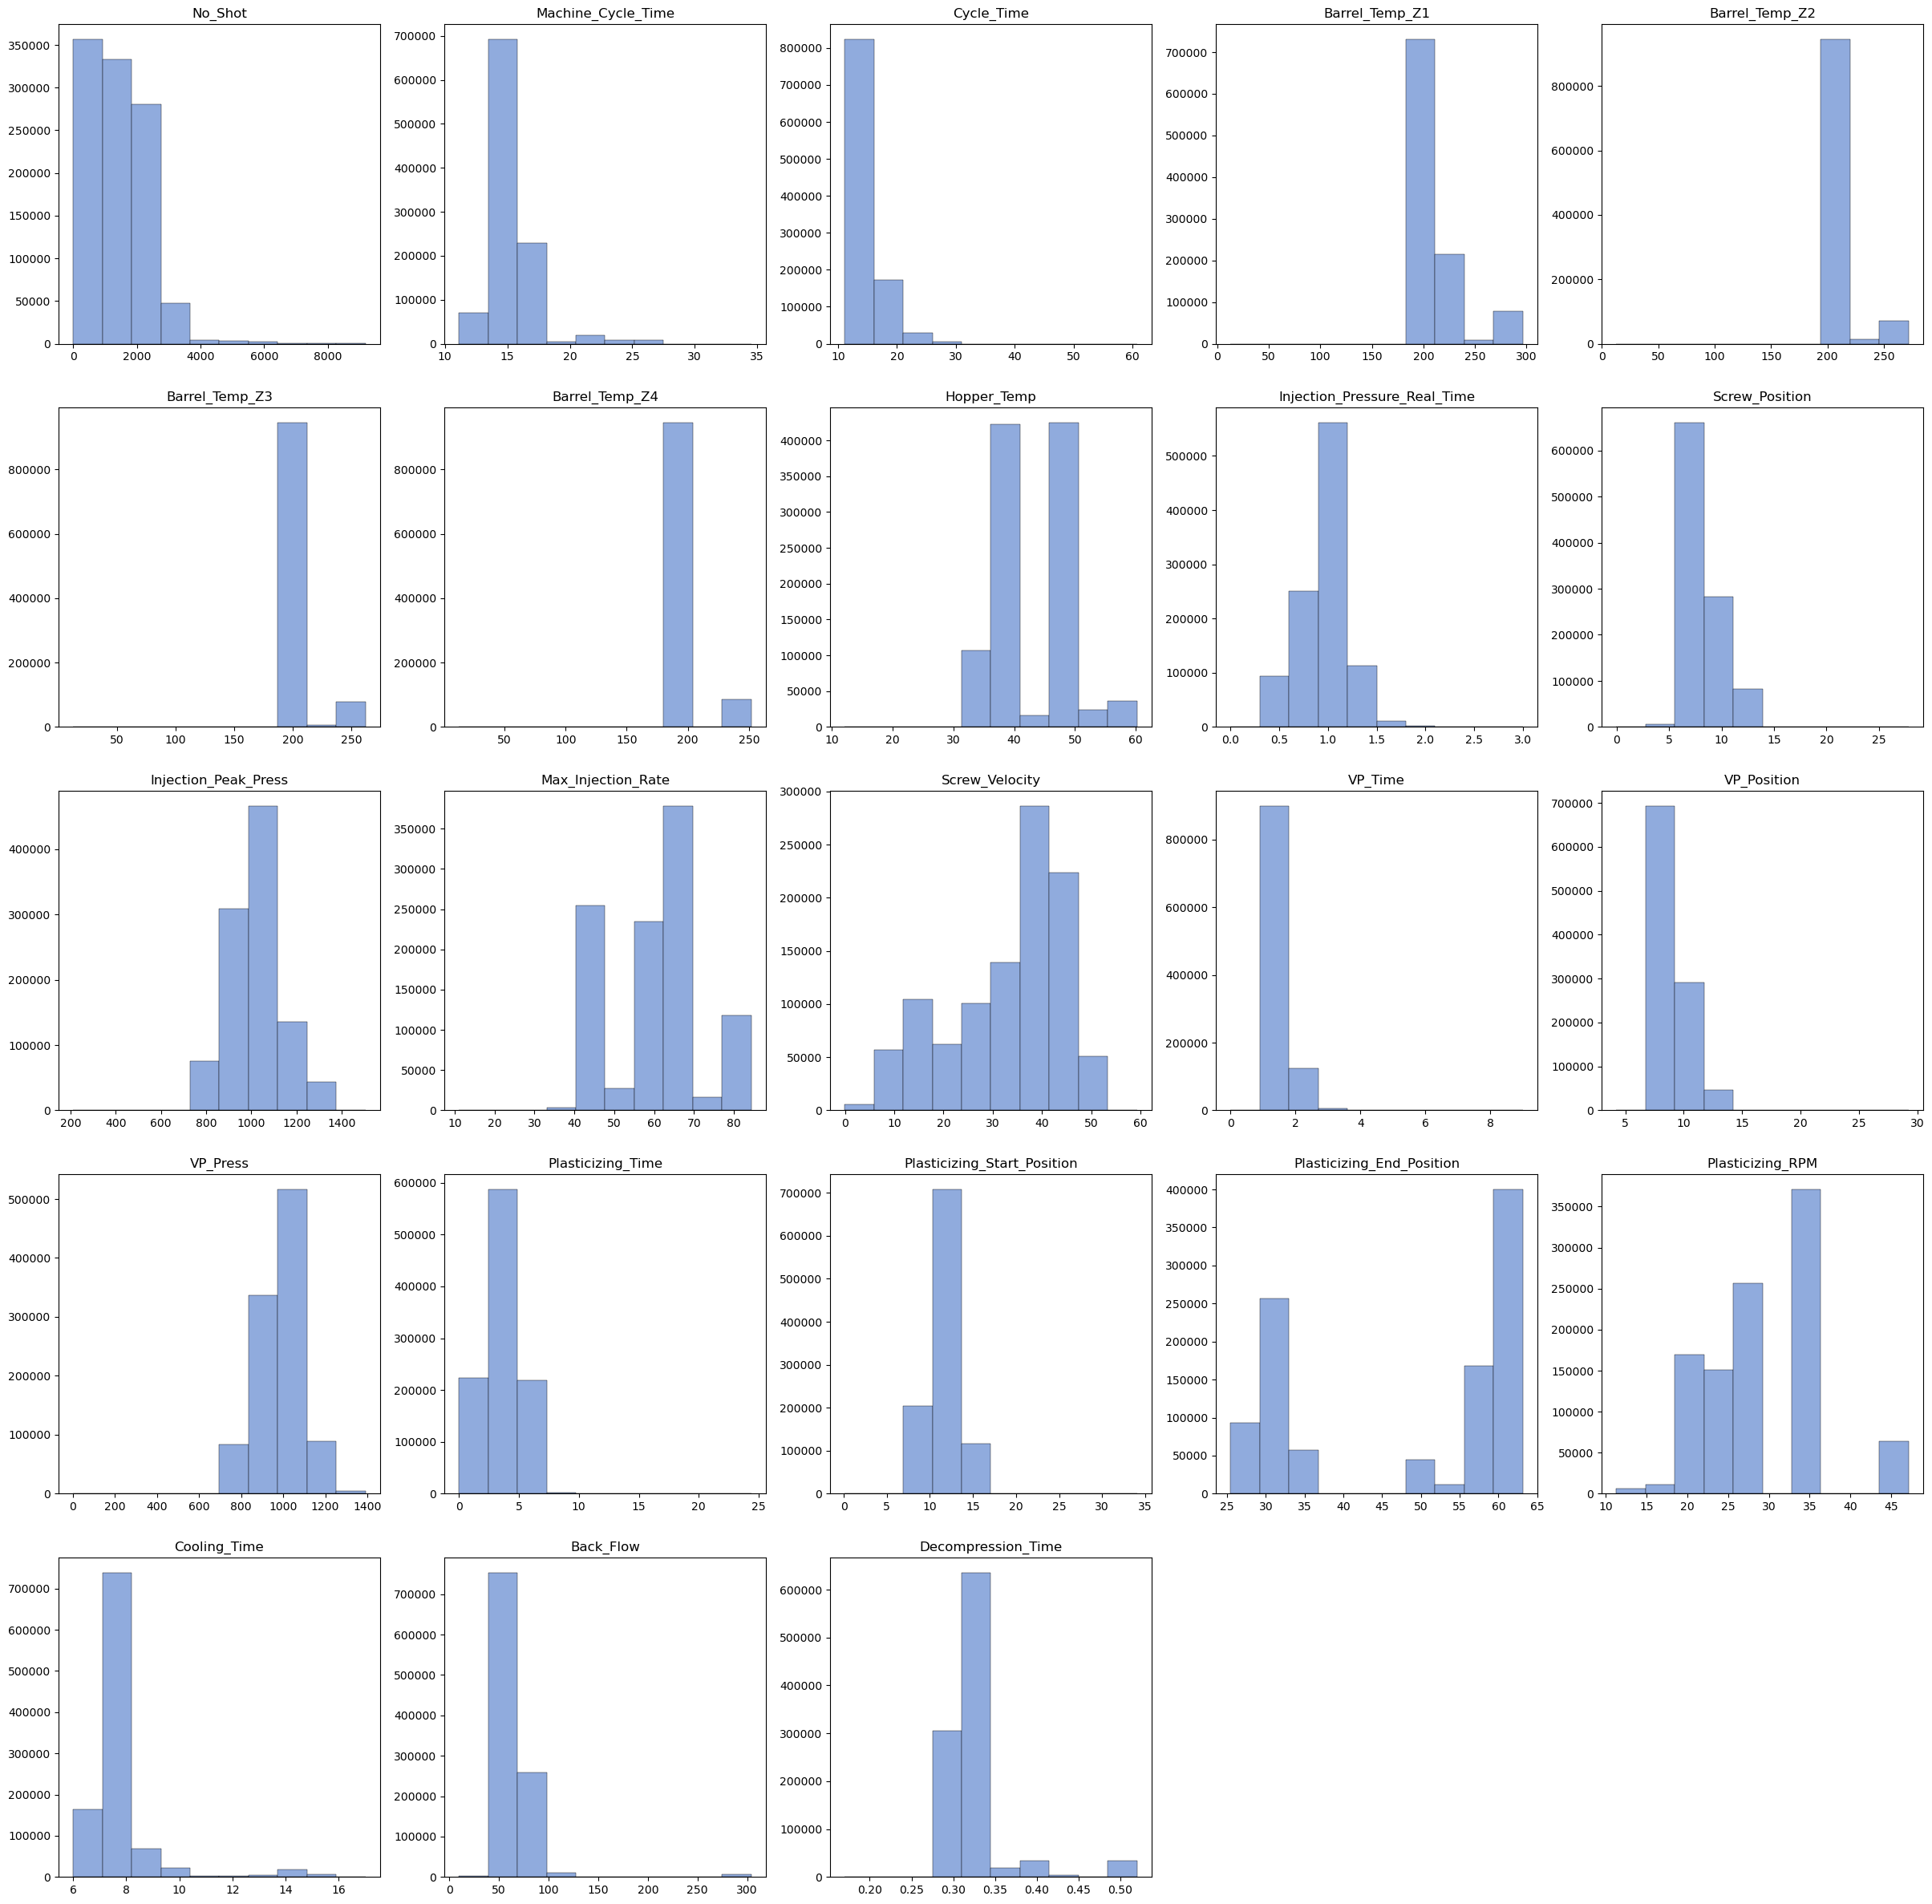

In [ ]:
# 히스토그램 시각화
plt.figure(figsize=(30,30))

for index, value in enumerate(data_drop):
    sub = plt.subplot(5,5,index+1)
    sub.hist(data_drop[value], facecolor = (144/255,171/255,221/255), linewidth=.3, edgecolor='black')
    plt.title(value)

데이터 상관분석

<Axes: >

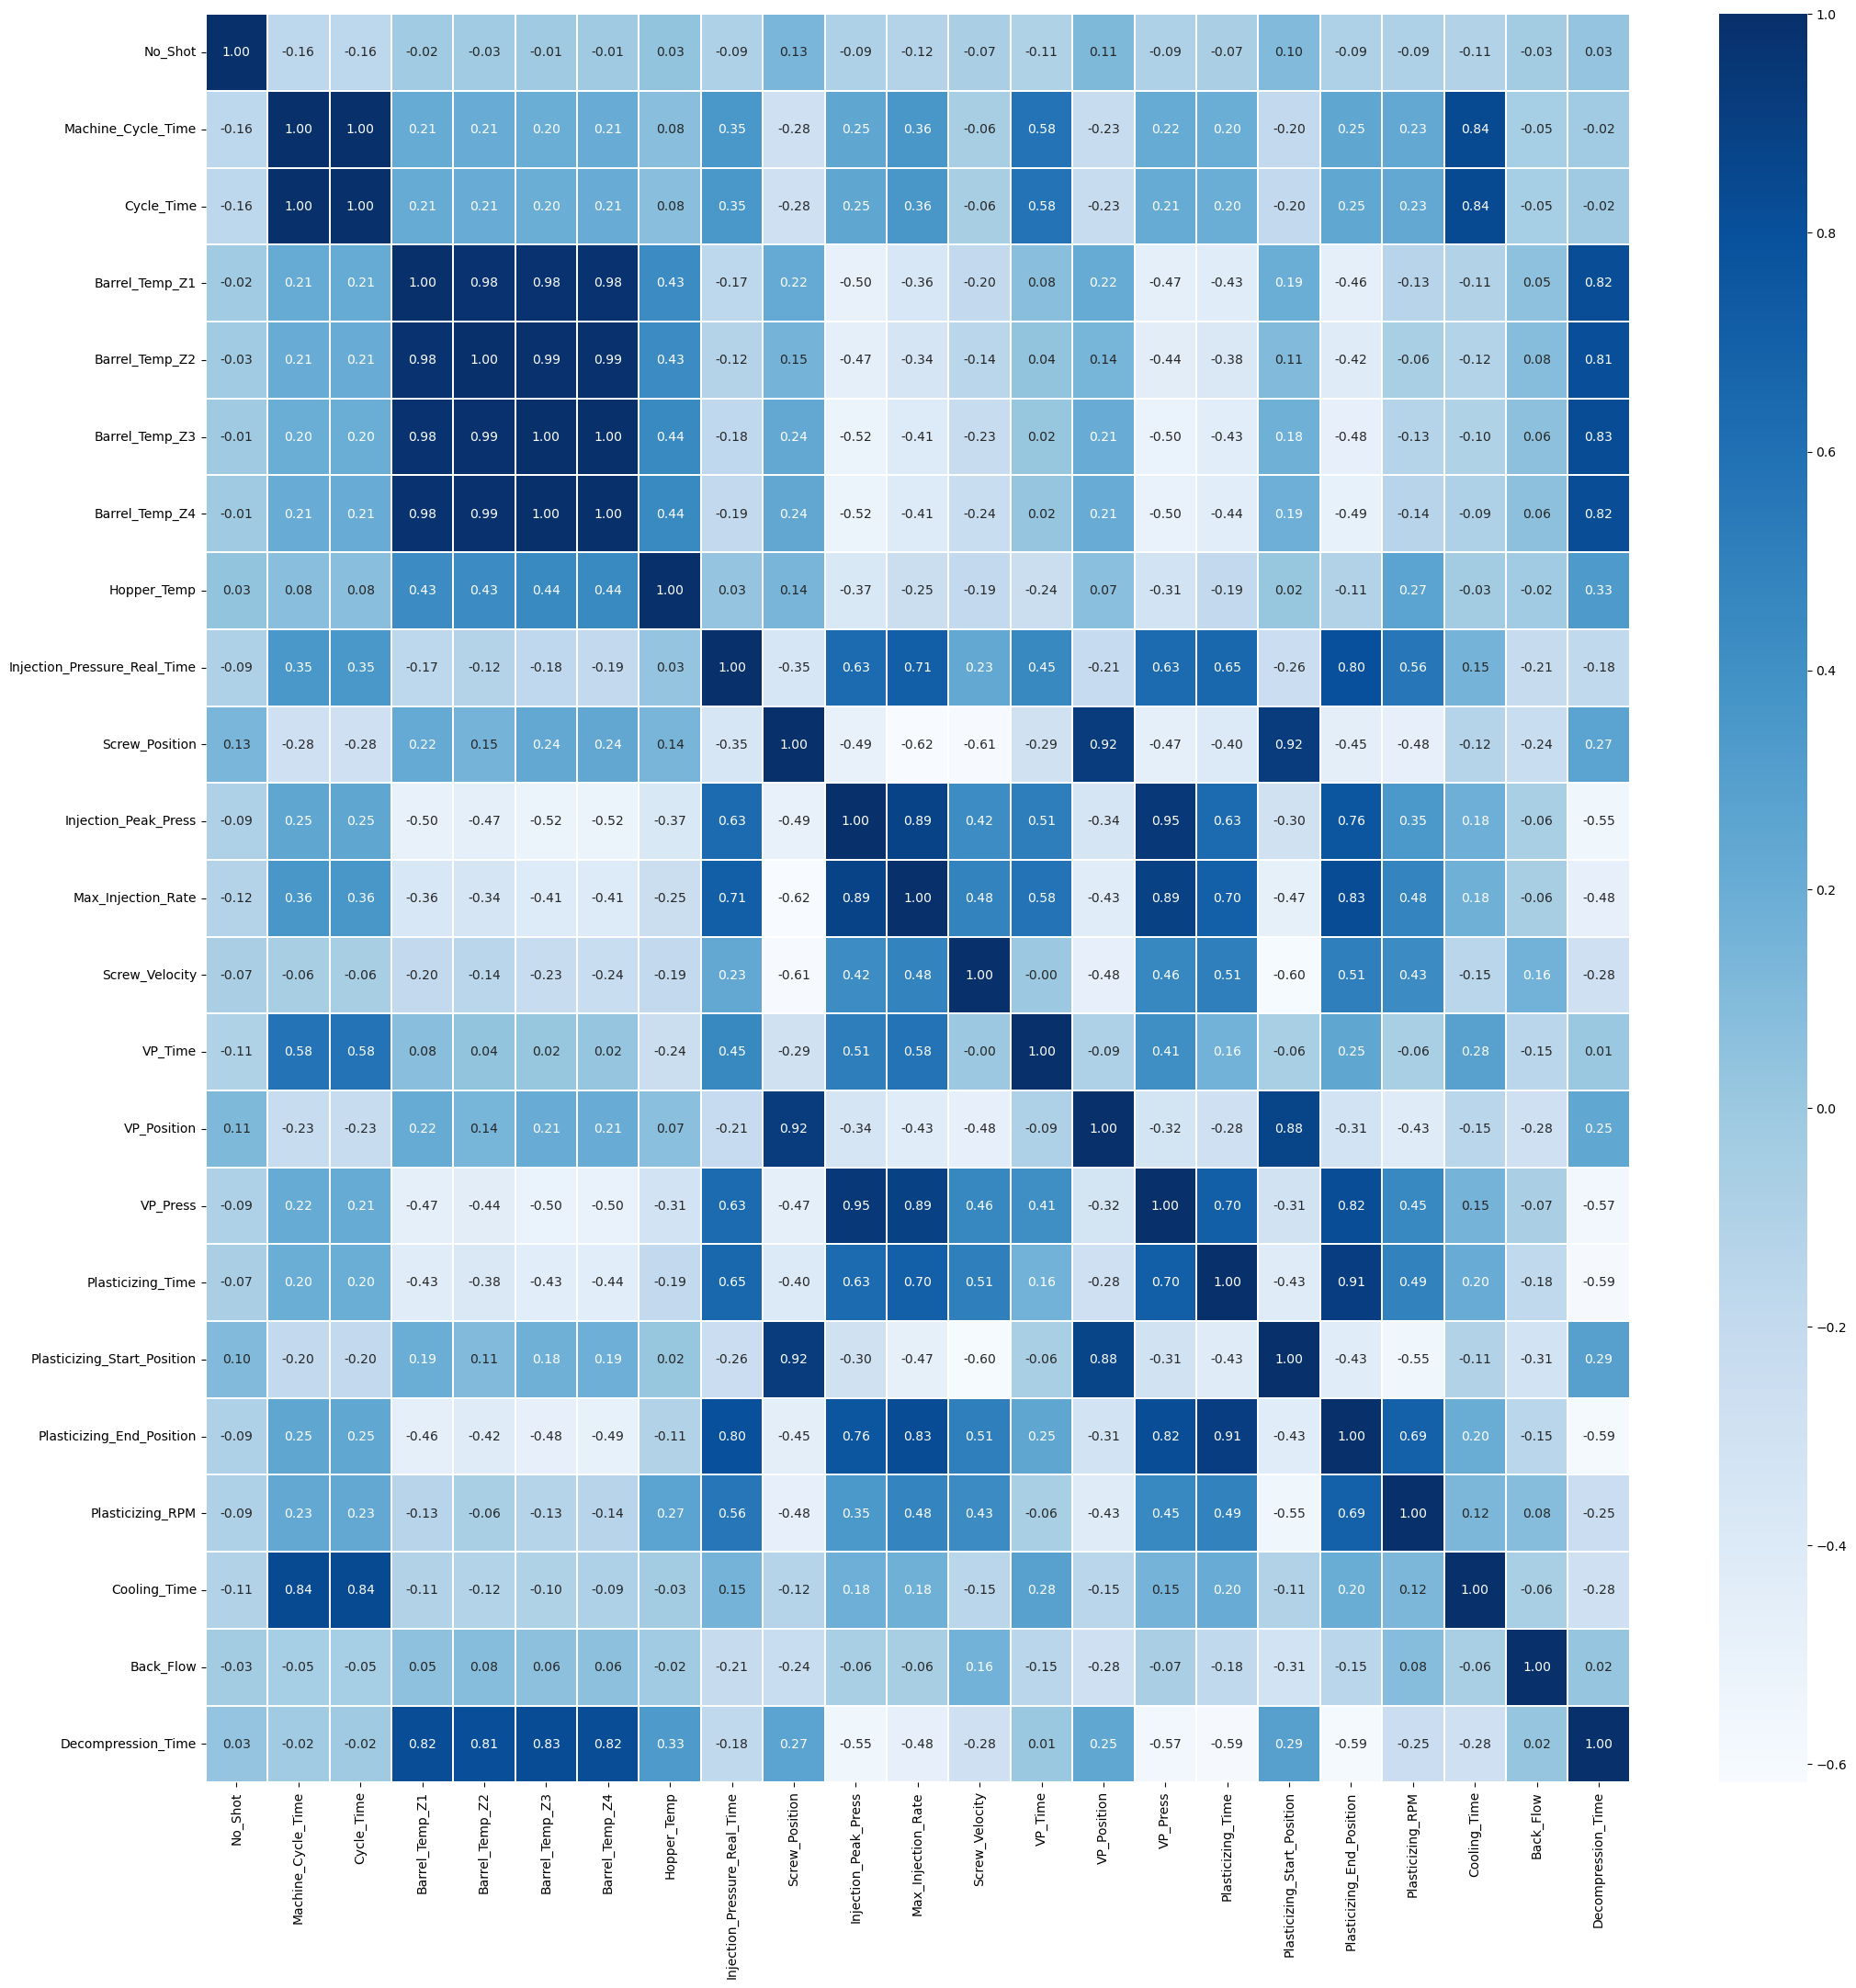

In [ ]:
# 상관계수 시각화
plt.subplots(figsize=(25,25))
sns.heatmap(data = data_drop.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

#### 학습/평가 데이터 준비

설비 normal/abnormal 레이블 생성

- 현재 설비의 상태를 나타내는 종속변수가 없는 비지도학습 데이터셋을 분석에 사용한다.

- 데이터의 특성 파악 및 군집을 통해 normal과 abnormal의 레이블 생성 작업을 한다.

Lot 단위 대표값 추출

In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 평균으로
data_list = []

for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].mean())

lot_mean = pd.DataFrame(data_list).drop(['No_Shot'], axis = 1)

In [ ]:
# Lot 별 평균값 데이터프레임 확인
lot_mean.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0           16.668679   16.681723      209.998316      200.042358   
1           16.660866   16.677780      209.999803      200.038804   
2           16.681288   16.699753      209.996035      200.036514   
3           16.634533   16.653553      209.998039      200.040196   
4           16.610939   16.624291      209.996946      200.031504   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0      194.962824      189.962435    40.085622                      1.367863   
1      195.007241      190.018890    40.089532                      1.363695   
2      195.001296      190.016765    40.078406                      1.382933   
3      195.001059      190.008471    40.090627                      1.338847   
4      195.009702      190.020371    40.125474                      1.308349   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  \
0        6.535635           1259.353666  ...      2.0     8.119780   
1        6.509563           1270.757599  ...      2.0     8.119437   
2        6.640133           1252.482285  ...      2.0     8.121991   
3        6.524275           1244.939608  ...      2.0     8.123667   
4        6.465195           1239.340870  ...      2.0     8.124291   

      VP_Press  Plasticizing_Time  Plasticizing_Start_Position  \
0  1184.873031           4.797461                    11.008510   
1  1161.965710           4.789536                    11.000386   
2  1184.553149           4.684229                    11.087640   
3  1113.798486           4.731149                    11.006322   
4  1109.827781           4.630274                    10.976884   

   Plasticizing_End_Position  Plasticizing_RPM  Cooling_Time  Back_Flow  \
0                  63.111632             28.27           8.0      49.03   
1                  63.111625             28.27           8.0      49.03   
2                  63.111457             28.27           8.0      49.03   
3                  63.111573             28.27           8.0      49.03   
4                  63.111736             28.27           8.0      49.03   

   Decompression_Time  
0            0.322306  
1            0.321893  
2            0.321735  
3            0.321718  
4            0.321701  

[5 rows x 22 columns]

In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 중앙값으로
data_list = []

for I in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].median())

    lot_median = pd.DataFrame(data_list).drop(['No_Shot'], axis=1)

# Lot 별 중앙값 데이터프레임 확인
lot_median.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0                15.1       15.12           290.0           270.0   
1                15.1       15.12           290.0           270.0   
2                15.1       15.12           290.0           270.0   
3                15.1       15.12           290.0           270.0   
4                15.1       15.12           290.0           270.0   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           260.0           250.0         55.8                          0.81   
1           260.0           250.0         55.8                          0.81   
2           260.0           250.0         55.8                          0.81   
3           260.0           250.0         55.8                          0.81   
4           260.0           250.0         55.8                          0.81   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0            9.23                776.95  ...      1.0        10.16    776.45   
1            9.23                776.95  ...      1.0        10.16    776.45   
2            9.23                776.95  ...      1.0        10.16    776.45   
3            9.23                776.95  ...      1.0        10.16    776.45   
4            9.23                776.95  ...      1.0        10.16    776.45   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               2.07                        11.68                      26.47   
1               2.07                        11.68                      26.47   
2               2.07                        11.68                      26.47   
3               2.07                        11.68                      26.47   
4               2.07                        11.68                      26.47   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           6.5      49.03                 0.4  
1             28.27           6.5      49.03                 0.4  
2             28.27           6.5      49.03                 0.4  
3             28.27           6.5      49.03                 0.4  
4             28.27           6.5      49.03                 0.4  

[5 rows x 22 columns]

In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 3분위수로
data_list = []

for I in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.75))

lot_75 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

# Lot별 3분위수 데이터프레임 확인
lot_75.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0               15.12       15.12           290.0           270.1   
1               15.12       15.12           290.0           270.1   
2               15.12       15.12           290.0           270.1   
3               15.12       15.12           290.0           270.1   
4               15.12       15.12           290.0           270.1   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           260.0           250.1         58.2                          0.81   
1           260.0           250.1         58.2                          0.81   
2           260.0           250.1         58.2                          0.81   
3           260.0           250.1         58.2                          0.81   
4           260.0           250.1         58.2                          0.81   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0            9.27                777.45  ...      1.0        10.17    776.83   
1            9.27                777.45  ...      1.0        10.17    776.83   
2            9.27                777.45  ...      1.0        10.17    776.83   
3            9.27                777.45  ...      1.0        10.17    776.83   
4            9.27                777.45  ...      1.0        10.17    776.83   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               2.09                        11.71                      26.47   
1               2.09                        11.71                      26.47   
2               2.09                        11.71                      26.47   
3               2.09                        11.71                      26.47   
4               2.09                        11.71                      26.47   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           6.5      49.03                 0.4  
1             28.27           6.5      49.03                 0.4  
2             28.27           6.5      49.03                 0.4  
3             28.27           6.5      49.03                 0.4  
4             28.27           6.5      49.03                 0.4  

[5 rows x 22 columns]

In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 1분위수로
data_list = []

for I in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.25))

lot_25 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

# Lot별 1분위수 데이터프레임 확인
lot_25.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0                15.1       15.12           290.0           270.0   
1                15.1       15.12           290.0           270.0   
2                15.1       15.12           290.0           270.0   
3                15.1       15.12           290.0           270.0   
4                15.1       15.12           290.0           270.0   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           260.0           250.0         52.6                           0.8   
1           260.0           250.0         52.6                           0.8   
2           260.0           250.0         52.6                           0.8   
3           260.0           250.0         52.6                           0.8   
4           260.0           250.0         52.6                           0.8   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0             9.2                776.45  ...      1.0        10.16    775.95   
1             9.2                776.45  ...      1.0        10.16    775.95   
2             9.2                776.45  ...      1.0        10.16    775.95   
3             9.2                776.45  ...      1.0        10.16    775.95   
4             9.2                776.45  ...      1.0        10.16    775.95   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               2.05                        11.65                      26.46   
1               2.05                        11.65                      26.46   
2               2.05                        11.65                      26.46   
3               2.05                        11.65                      26.46   
4               2.05                        11.65                      26.46   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           6.5      49.03                 0.4  
1             28.27           6.5      49.03                 0.4  
2             28.27           6.5      49.03                 0.4  
3             28.27           6.5      49.03                 0.4  
4             28.27           6.5      49.03                 0.4  

[5 rows x 22 columns]

IQR 기반 abnormal 데이터 정의

In [ ]:
# IQR을 통한 이상치 분류 함수
def outliers_iqr(data):

    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)

    return np.where((data>upper_bound)|(data<lower_bound))

In [ ]:
# Lot별 대표값을 통한 abnormal 탐색 함수
# 각 컬럼별 이상치가 4개 이상인 Lot 번호(index)를 abnormal이라 판단
def outlier_search(lot_rep):

    rep_index = []

    for i in range(lot_rep.shape[1]):
        rep_index.append(outliers_iqr(lot_rep[lot_rep.columns[i]])[0])

    a = 0
    outlier_index = []

    for i in range(len(lot_rep)):
        a = 0
        for j in rep_index:
            if i in j:
                a = a + 1
        if a > 3:
            outlier_index.append(i)

    return outlier_index

In [ ]:
# 각 대표값 별 abnormal 합집합
IQR_error= sorted((list(set(outlier_search(lot_mean)+outlier_search(lot_median)+
                            outlier_search(lot_75)+outlier_search(lot_25)))))

- 정의한 이상치 분류 함수에 Lot별 대표값 데이터프레임을 적용하였고 정의한
‘outlier_search’ 함수를 통해 각 컬럼별 이상치가 4개 이상인 인덱스들을 abnormal
이라 판단한다. 네 종류 대표값의 데이터 프레임을 적용한 abnormal Lot의 번호를
리스트 변수에 저장한다.

- 첫 번째 for문에서 분석에 사용되는 23개의 공정 변수를 전부 ‘outliers_iqr’ 함수에
적용한다. 이를 통해 공정 변수별로 normal 상태를 벗어난 Lot의 번호를 rep_index
리스트 변수에 저장하여 총 23개의 abnormal Lot 번호 리스트를 저장하게 된다. 이
후 조건문을 통해 23개의 abnormal Lot 번호 리스트 중 전체 Lot의 번호인 0~ 380
번 사이에 중복이 되는 Lot 번호가 4개 이상일 때, 즉 normal 상태를 벗어난 공정 변
수의 개수가 4개 이상인 Lot 번호(index)를 abnormal이라 판단하여 IQR_error 리
스트 함수에 저장한다. 이와 같은 과정을 평균, 중앙값, 1분위, 3분위 총 네 번의 과정
을 거쳐 나오게 된 Lot 번호의 합집합을 abnormal이라 판단하여 라벨링에 사용한다.

In [ ]:
print(IQR_error)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 100, 101, 102, 103, 113, 114, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]


IQR_error 리스트 함수에 저장되어 있는 Lot 번호를 확인한다.

DBSCAN 기반 abnormal 데이터 정의

In [ ]:
# x: 독립변인들의value값만추출
# y: 종속변인추출
x = lot_mean.drop(['Machine_Cycle_Time'], axis=1).values
y = lot_mean['Machine_Cycle_Time'].values

print(x)
print(y)

[[ 16.6817228  209.99831606 200.04235751 ...   8.          49.03
    0.3223057 ]
 [ 16.6777804  209.99980323 200.03880362 ...   8.          49.03
    0.32189296]
 [ 16.69975265 209.99603455 200.03651355 ...   8.          49.03
    0.32173537]
 ...
 [ 15.03512623 290.0004279  270.00937099 ...   6.5        294.095092
    0.40015832]
 [ 15.04763788 289.99823101 270.00551509 ...   6.5        270.89907041
    0.40002775]
 [ 15.11659289 289.99698189 270.00449363 ...   6.5         49.03
    0.40004695]]
[16.66867876 16.6608658  16.68128779 16.63453333 16.61093931 16.6151929
 16.58832691 16.57856909 16.57410649 16.58617455 16.57820364 16.72306075
 16.75241763 16.75701087 16.75403175 16.63455809 16.59659591 16.62254495
 16.80313367 16.84316706 17.68217195 17.77893662 17.84900671 15.36076759
 15.36549466 15.34459016 15.34107973 15.34620347 15.33777937 15.33592357
 15.40422806 15.42330417 15.39479226 15.3918394  16.54459239 16.54473563
 16.58713622 16.53754898 16.53392337 16.5463401  16.56390929 

In [ ]:
# x객체에 x를 표준화한 데이터를 저장 - 독립변인 표준화
x = MinMaxScaler().fit_transform(x)

- 시각화를 통한 데이터 분포의 경향성을 파악하기에는 분석에 사용되는 변수가 다양
하기 때문에 한계가 존재한다. 따라서 여러 변수 간 존재하는 상관관계를 이용해 이를
대표하는 주성분을 추출해 차원을 축소하는 기법인 PCA를 이용한다. 공정 변수 중 데
이터셋의 중요 변수인 사이클 타임, 즉 'Machine_Cycle_Time'을 drop() 함수를 이
용하여 종속변인으로 설정하고 데이터를 2차원으로 축소하여 데이터 분포의 경향성
을 시각화한다.

- sklearn package의 전처리(preprocessing) 함수 중 MinMaxScaler()를 사용하여
raw data를 스케일링한다. raw data는 변수마다 수치의 크기와 평균, 분산 등의 통
계치가 다르고, 특히 지나치게 낮거나 높은 값인 아웃라이어(outlier)가 존재할 수 있
으므로 모델의 성능에 악영향을 미칠 수 있다. 스케일링을 통해 모델의 성능을 제고하
고 데이터를 정제하는 결과를 얻게 된다.

In [ ]:
# 2개의 주성분(n_components)으로 이루어진 데이터프레임 구성
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

print(principalDf)

     principal component1  principal component2
0               -0.873603              0.343205
1               -0.865574              0.340311
2               -0.837708              0.320043
3               -0.785490              0.296093
4               -0.766725              0.286019
..                    ...                   ...
376              1.738420              0.916883
377              1.738848              0.917567
378              1.709417              0.978951
379              1.706065              0.974776
380              1.743391              0.915489

[381 rows x 2 columns]


In [ ]:
#PCA를 통한 차원축소 확인
principalDf.head()

principal component1  principal component2
0             -0.873603              0.343205
1             -0.865574              0.340311
2             -0.837708              0.320043
3             -0.785490              0.296093
4             -0.766725              0.286019

In [ ]:
# epsilon, 최소 샘플 개수 설정
# 모델을 DBSCAN 알고리즘 사용
# DBSCAN 알고리즘 파라미터 설정 및 저장
a = 0.165
b = 10
model = DBSCAN(eps=a, min_samples=b)

- 시각화를 위한 차원 축소 이후 데이터 간 경향성을 파악하기 위해 클러스터링 알고리
즘을 사용한다. 비지도 학습 알고리즘 모델은 DBSCAN 알고리즘을 사용하며 밀도를
이용하여 점의 주위로 군집화를 하고 군집화된 데이터들 간 경향성이 제일 다른 군집
을 abnormal이라 분류한다.
- model 객체 변수에 DBSCAN() 모델을 생성하여 저장한다. 모델을 사용하기에 앞서
epsilon과 최소 샘플 개수를 각각 a, b에 저장하여 설정한다. 여기서 epsilon은 주어
진 객체들의 반경을 의미한다

In [ ]:
# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(principalDf)
principalDf['cluster'] = model.fit_predict(principalDf)

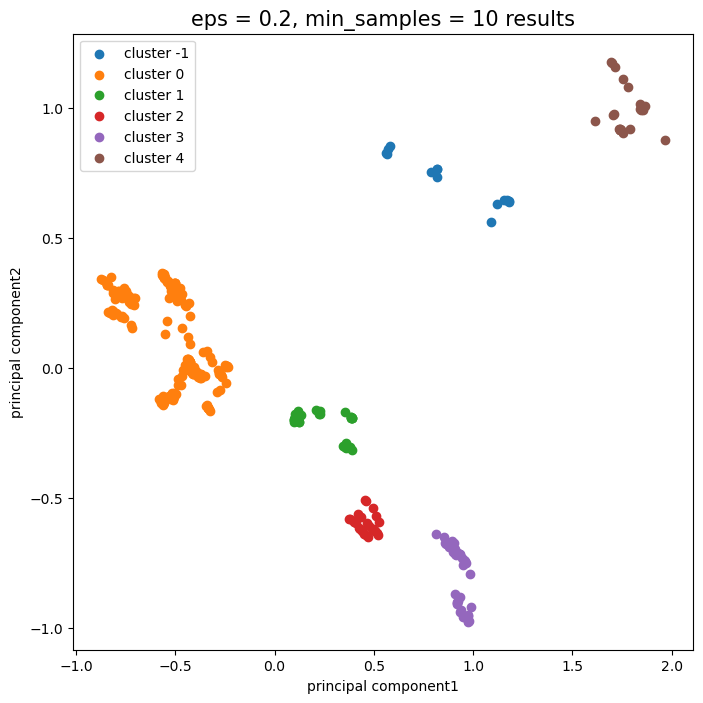

In [ ]:
# matplotlib 라이브러리를 통한 군집 시각화
# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
plt.figure(figsize=(8,8))

for i in range(-1, principalDf['cluster'].max() + 1):
    plt.scatter(principalDf.loc[principalDf['cluster'] == i, 'principal component1'],
        principalDf.loc[principalDf['cluster'] == i, 'principal component2'],
            label = 'cluster ' + str(i))

plt.legend()
plt.title('eps = %.1f, min_samples = %d results'%(a, b), size=15)
plt.xlabel('principal component1', size=10)
plt.ylabel('principal component2', size=10)
plt.show()

In [ ]:
# DBSCAN 군집화를 통해 발견한 abnormal 예상 Lot 분류
DB_error=[]

for i in range(len(principalDf)):
    if principalDf['cluster'][i]==4:
        DB_error.append(i)
    elif principalDf['cluster'][i]==-1:
        DB_error.append(i)

# abnormal이라 판단되는 Lot 번호를 DB_error 리스트 변수에 저장한다. 이후 해당 Lot 번호를 라벨링에 사용

In [ ]:
# IQR을 통한 abnormal Lot 번호와 DBSCAN을 통한 abnormal Lot 번호의 합집합
# 총 43개의 Lot을 abnormal이라 판단
error_list = sorted(list(set(IQR_error + DB_error)))
print('abnormal Lot 번호:', error_list)
print('abnormal Lot 개수:', len(error_list))

abnormal Lot 번호: [85, 86, 87, 88, 89, 90, 91, 92, 93, 100, 101, 102, 103, 113, 114, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]
abnormal Lot 개수: 41


설비 normal / abnormal 레이블 부여

In [ ]:
# Shot 데이터에 Lot 번호 라벨링

n_Lot_list = []

for i in range(len(data_n_lot)):
    a = i
    Lot_label = data_n_lot[i].copy()
    Lot_label.loc[:,['Lot']] = a
    n_Lot_list.append(Lot_label)

C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.colu

C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\1648627188.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.colu

In [ ]:
# concat 함수를 통한 데이터 결합
data_lot_label = n_Lot_list[0]
for i in range(len(n_Lot_list)):
    if i == 0:
        pass
    else:
        data_lot_label = pd.concat([data_lot_label, n_Lot_list[i]])

data_lot_label = data_lot_label.reset_index(drop=True)

In [ ]:
# abnormal shot 라벨링

data_lot_label.loc[:, ['PassOrFail']] = 0

for i in range(len(data_lot_label)):
    if data_lot_label['Lot'][i] in error_list:
        data_lot_label.loc[i,['PassOrFail']]=1

data_shot_label = data_lot_label.copy().drop(['No_Shot'],axis=1)

C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\248831294.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_lot_label.loc[:, ['PassOrFail']] = 0


In [ ]:
data_shot_label

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0                     16.54       16.52           210.2           200.7   
1                     16.56       16.54           210.2           200.8   
2                     16.58       16.56           210.1           200.7   
3                     16.62       16.58           210.1           200.6   
4                     16.62       16.62           210.0           200.5   
...                     ...         ...             ...             ...   
1030409               15.12       15.12           290.0           270.0   
1030410               15.10       15.14           290.0           269.9   
1030411               15.10       15.12           290.0           270.0   
1030412               15.10       15.10           290.0           270.0   
1030413               15.10       15.12           290.0           270.0   

         Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  \
0                 193.5           187.3         40.1   
1                 193.5           187.2         40.2   
2                 193.5           187.2         40.2   
3                 193.5           187.2         40.2   
4                 193.4           187.3         40.1   
...                 ...             ...          ...   
1030409           260.0           250.0         51.8   
1030410           260.0           250.0         52.0   
1030411           260.0           250.0         52.2   
1030412           259.9           249.9         52.4   
1030413           260.0           250.0         52.6   

         Injection_Pressure_Real_Time  Screw_Position  Injection_Peak_Press  \
0                                1.23            6.02               1211.65   
1                                1.24            6.02               1211.65   
2                                1.26            6.02               1209.16   
3                                1.30            6.28               1228.24   
4                                1.31            6.46               1287.11   
...                               ...             ...                   ...   
1030409                          0.82            9.29                778.07   
1030410                          0.80            9.29                777.58   
1030411                          0.80            9.23                777.20   
1030412                          0.81            9.24                777.83   
1030413                          0.80            9.19                776.83   

         ...  VP_Position  VP_Press  Plasticizing_Time  \
0        ...         8.14   1062.00               4.74   
1        ...         8.14   1062.00               4.81   
2        ...         8.12   1101.41               4.80   
3        ...         8.12   1092.55               4.84   
4        ...         8.10   1153.41               4.86   
...      ...          ...       ...                ...   
1030409  ...        10.16    777.45               2.05   
1030410  ...        10.16    777.08               2.04   
1030411  ...        10.18    776.70               2.05   
1030412  ...        10.16    777.58               2.02   
1030413  ...        10.17    776.45               2.03   

         Plasticizing_Start_Position  Plasticizing_End_Position  \
0                              10.46                      63.11   
1                              10.49                      63.11   
2                              10.53                      63.11   
3                              10.78                      63.11   
4                              10.94                      63.11   
...                              ...                        ...   
1030409                        11.72                      26.47   
1030410                        11.74                      26.46   
1030411                        11.66                      26.47   
1030412                        11.67                      26.47   
1030413                        11.65                

- 하나의 데이터프레임으로 만든 후, 분석에 사용하기 위해 abnormal 이라 예측되는
Lot 번호의 Shot 데이터에 ‘PassOrFail’ 변수를 만들어서 라벨링을 새로 부여한다. 0
은 normal, 1은 abnormal을 의미한다.

In [ ]:
# 라벨링 갯수 비교
data_shot_label['PassOrFail'].value_counts()

0    940818
1     89596
Name: PassOrFail, dtype: int64

In [ ]:
# 분석에 영향을 끼칠 수 있는 ‘Lot’ 컬럼을 drop()함수를 통해 삭제
data_shot_label = data_shot_label.copy().drop(['Lot'],axis=1)

데이터 2차 데이터 전처리

In [ ]:
# Lot별 평균 데이터 스케일링

scaler = MinMaxScaler()

df_sum_drop_scaler = scaler.fit_transform(data_shot_label)
df_sum_drop_scaler = pd.DataFrame(df_sum_drop_scaler)

데이터 분리

In [ ]:
# normal shot
df_Y_scaler = df_sum_drop_scaler[df_sum_drop_scaler[22]==0]
print('normal shot:', len(df_Y_scaler))
# abnormal shot
df_N_scaler = df_sum_drop_scaler[df_sum_drop_scaler[22]==1]
print('abnormal shot:', len(df_N_scaler))

normal shot: 940818
abnormal shot: 89596


In [ ]:
# ‘PassOrFail’ 변수 제거
df_Y_scaler = df_Y_scaler.drop(columns=[22])
df_N_scaler = df_N_scaler.drop(columns=[22])

오토인코더 모델에 학습시킬 데이터의 형태는 클래스 변수가 없어야 하므로 변수
(‘PassOrFail’)를 제거한다.

In [ ]:
# 학습 데이터, 평가데이터(normal shot)
Y_train, Y_test = train_test_split(df_Y_scaler, test_size = 0.3, random_state = 1234)
# 평가 데이터(abnromal shot)
N_test = df_N_scaler
print('normal 학습 데이터셋 개수:', len(Y_train))
print('normal 평가 데이터셋 개수:', len(Y_test))
print('abnormal 평가 데이터셋 개수:', len(N_test))

normal 학습 데이터셋 개수: 658572
normal 평가 데이터셋 개수: 282246
abnormal 평가 데이터셋 개수: 89596


- 본 분석에서는 오토인코더 모델에 normal 데이터만 학습에 활용할 예정이므로,
normal과 abnormal 데이터 분리가 필수적이다. df_Y_scaler는 normal 데이터만,
df_N_scaler는 abnormal 데이터만 포함하게 된다. df_Y_scaler는 학습데이터인
Y_train과 평가 데이터인 Y_test로 나눠서 저장하고 df_N_scaler는 평가 데이터인
N_test로 저장해서 AI 모델 훈련에 사용하게 된다.
- 단순 슬라이싱으로 데이터를 분리하면 특정 데이터만 학습이 될 수 있기 때문에
sklearn의 train_test_split을 통해 데이터를 임의로 나눠서 분리하게 한다. test_size
는 분리하는 전체 데이터의 비율을 의미하고, random_state는 재현 가능하도록 난
수의 초기 값을 설정해두는 것이기 때문에 다른 결과를 원하면 다르게 설정한다.

#### AI 모델 구축

In [ ]:
# 인코더
dropout_encoder = Sequential([
Dropout(0.3),
Dense(15, activation="relu"), # 첫 번째 은닉층
Dense(5, activation="relu") # 두 번째 은닉층
])
# 디코더
dropout_decoder = Sequential([
Dense(15, activation="relu", input_shape=[5]), # 세 번째 은닉층
Dense(Y_train.shape[1], activation='relu'), # 출력
])
dropout_AE = Sequential([dropout_encoder, dropout_decoder])

- Tensorflow Keras package의 Sequential 모델을 사용하여 순서대로 연결된 층
을 일렬로 쌓아서 구성한다. 인코더와 디코더, 두 개를 합친 오토인코더 모델을 구
성할 때 Sequential을 사용한다. 훈련에 필요한 계산과 모델을 표현한 구조를 구성
하는 과정에서 입력층, 은닉층, 출력층의 크기와 학습 속도 및 드롭아웃 비율을 직접
설정해줄 수 있으며, 이렇게 직접 설정해주는 파라미터를 하이퍼 파라미터 (hyperparameter)
라고 한다.
- 첫 번째 레이어로 Dropout 은닉층을 추가하고 드롭아웃 비율을 0.3 으로 설정한다.
뉴런을 15개 혹은 5개를 가진 Dense 은닉층을 추가하고, ‘Relu’ 활성화 함수를 사용
하여 층마다 각자 가중치 행렬을 관리하도록 한다.
- ‘Relu’는 0보다 작은 입력은 0으로 만들고, 0보다 큰 입력은 그대로 내보내게 되면서
연산 비용을 줄임으로써 빠른 학습을 가능하게 한다.

In [ ]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# 모델 훈련
history = dropout_AE.fit(Y_train, Y_train, batch_size=30, epochs=30, validation_split=0.2,
                        callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

Epoch 1/30
17562/17562 [==============================] - 17s 963us/step - loss: 0.0166 - accuracy: 0.6334 - val_loss: 0.0082 - val_accuracy: 0.2334
Epoch 2/30
17562/17562 [==============================] - 17s 959us/step - loss: 0.0026 - accuracy: 0.7442 - val_loss: 0.0078 - val_accuracy: 0.3060
Epoch 3/30
17562/17562 [==============================] - 17s 956us/step - loss: 0.0026 - accuracy: 0.7475 - val_loss: 0.0100 - val_accuracy: 0.1946
Epoch 4/30
17562/17562 [==============================] - 17s 962us/step - loss: 0.0025 - accuracy: 0.7452 - val_loss: 0.0084 - val_accuracy: 0.3906
Epoch 5/30
17562/17562 [==============================] - 17s 962us/step - loss: 0.0025 - accuracy: 0.7448 - val_loss: 0.0077 - val_accuracy: 0.5067
Epoch 6/30
17562/17562 [==============================] - 17s 958us/step - loss: 0.0028 - accuracy: 0.7397 - val_loss: 0.0059 - val_accuracy: 0.5548
Epoch 7/30
17562/17562 [==============================] - 17s 957us/step - loss: 0.0028 - accuracy: 0.7391

- 모델을 만들고 나서 compile() 메서드를 호출하여 손실 함수로는 평균 제곱 오차
(Mean Squared Error, MSE)를 사용하고, 옵티마이저로는 Adam을 사용한다. 훈련
과 평가 시에 정확도를 측정하기 위해 “accuracy”로 평가 지표로 설정한다.
- 모델을 훈련하기 위해서 fit() 메서드를 호출한다. 복원 모델이기 때문에 입력과 출력
모두 동일하게 normal의 학습 데이터(Y_train)로 설정한다. 데이터를 작은 묶은 단
위로 쪼갠 미니배치(mini-batch)를 순차적으로 모델에 주입하는 것이 한 번에 모든
학습 데이터를 주입하는 것보다 빠르고 적은 비용(손실)으로 학습할 수 있다. 배치 크
기를 30개로 설정함으로써 데이터를 30개씩 쪼개고, 에포크 (epoch)를 30으로 두어
모델을 30번 학습시킨다. 검증 데이터는 학습 데이터의 20%를 사용한다. 학습 에포
크마다 처리한 데이터 개수와 데이터마다 걸린 평균 학습 시간, 학습 데이터와 검증
데이터에 대한 손실과 정확도를 출력한다.
- 콜백(callback)은 모델의 fit() 메서드가 호출될 때 전달되는 객체이다. 훈련하는 동안
모델은 여러 지점에서 콜백을 호출하여 모델의 상태와 성능에 대한 모든 정보에 접근
하고 훈련을 중지하거나 모델을 저장하고, 가중치를 적재하거나 모델 상태를 변경할
수 있다. 이 모델에서는 케라스 콜백 함수의 조기종료(early stopping)를 사용하여 검
증 손실값이 더이상 향상되지 않을 때 훈련을 중지한다.
- monitor는 관찰하고자 하는 항목이고, 검증 손실값이나 검증 정확도인 ‘val_loss’나
‘val_acc’가 주로 사용된다.
- patience는 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려
줄 것인가를 지정하는 값이다.
- mode는 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준이며, 관찰 항목이 ‘val_
loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로 ‘min’으로 설정한다.

#### 결과 분석

In [ ]:
# 학습 데이터의 예측값
train_pred = dropout_AE.predict(Y_train)
# 학습 데이터의 복원 오차 (예측값 실제값)
train_loss = np.mean(np.square(train_pred-Y_train),axis=1)
# 임계치
threshold = np.mean(train_loss) + 5*np.std(train_loss)
print("복원 오류 임계치:", threshold)

20581/20581 [==============================] - 13s 605us/step
복원 오류 임계치: 0.04412519581990604


In [ ]:
# 예측값
predict_Y = dropout_AE.predict(Y_test)
# normal 평가 데이터의 복원 오차 (예측값 실제값)
test_Y_mse = np.mean(np.square(predict_Y - Y_test),axis=1)
# normal로 판단한 데이터 확인
test_Y_anomalies = test_Y_mse > threshold
print("normal로 판단한 데이터 확인:\n", test_Y_anomalies)

8821/8821 [==============================] - 5s 610us/step
normal로 판단한 데이터 확인:
 905443    False
118764    False
865622    False
209812    False
226823    False
          ...  
580449    False
764638    False
73006     False
408231    False
600413    False
Length: 282246, dtype: bool


In [ ]:
# 예측값
predict_N = dropout_AE.predict(df_N_scaler)
# abnormal 평가 데이터의 복원 오차 (예측값 실제값)
test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
# abnormal로 판단한 데이터 확인
test_N_anomalies = test_N_mse > threshold
print("abnormal로 판단한 데이터 확인:\n", test_N_anomalies)

2800/2800 [==============================] - 2s 611us/step
abnormal로 판단한 데이터 확인:
 210410     True
210411     True
210412     True
210413     True
210414     True
           ... 
1030409    True
1030410    True
1030411    True
1030412    True
1030413    True
Length: 89596, dtype: bool


In [ ]:
true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
accuracy = np.round(accuracy_score(true,prediction), 4)
recall = np.round(recall_score(true,prediction,pos_label=0), 4)
precision = np.round(precision_score(true,prediction,pos_label=0), 4)
f1_score = np.round((2*recall*precision/(recall+precision)), 4)
print(confusion_matrix(true,prediction))
print('정확도:', accuracy)
print('재현율:', recall)
print('정밀도:', precision)
print('f1-score', f1_score)

[[282238      8]
 [     0  89596]]
정확도: 1.0
재현율: 1.0
정밀도: 1.0
f1-score 1.0


#### 성능 개선

하이퍼 파라미터 조절

In [ ]:
# 노드 22, 11 drop out = 0.3, patience = 8, threshold = 1.5
# 정확도 정밀도가 높아지고, 혼동행렬을 통해 abnormal과 normal을 고루 잡아낼 수 있는것을 확인
# 인코더
dropout_encoder=Sequential([
Dropout(0.3),
Dense(22, activation="relu"), # 첫 번째 은닉층
Dense(11, activation="relu") # 두 번째 은닉층
])
# 디코더
dropout_decoder=Sequential([
Dense(22, activation="relu", input_shape=[11]), # 세 번째 은닉층
Dense(Y_train.shape[1], activation='relu'), # 출력
])
dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [ ]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# 모델 훈련
history = dropout_AE.fit(Y_train, Y_train, batch_size=30, epochs=30, validation_split=0.2,
callbacks=[EarlyStopping(monitor="val_loss", patience=8, mode="min")])

Epoch 1/30
17562/17562 [==============================] - 18s 972us/step - loss: 0.0146 - accuracy: 0.7594 - val_loss: 0.0147 - val_accuracy: 0.1767
Epoch 2/30
17562/17562 [==============================] - 17s 970us/step - loss: 0.0020 - accuracy: 0.7870 - val_loss: 0.0111 - val_accuracy: 0.1760
Epoch 3/30
17562/17562 [==============================] - 17s 968us/step - loss: 0.0019 - accuracy: 0.7883 - val_loss: 0.0096 - val_accuracy: 0.3533
Epoch 4/30
17562/17562 [==============================] - 17s 970us/step - loss: 0.0019 - accuracy: 0.7886 - val_loss: 0.0082 - val_accuracy: 0.1833
Epoch 5/30
17562/17562 [==============================] - 17s 970us/step - loss: 0.0019 - accuracy: 0.7867 - val_loss: 0.0139 - val_accuracy: 0.1748
Epoch 6/30
17562/17562 [==============================] - 17s 968us/step - loss: 0.0019 - accuracy: 0.7879 - val_loss: 0.0153 - val_accuracy: 0.2714
Epoch 7/30
17562/17562 [==============================] - 17s 969us/step - loss: 0.0019 - accuracy: 0.7895

In [ ]:
# 학습 데이터의 예측값
train_pred = dropout_AE.predict(Y_train)
# 학습 데이터의 복원 오차 (예측값 실제값)
train_loss = np.mean(np.square(train_pred-Y_train), axis=1)
# 임계치
threshold = np.mean(train_loss) + 1.5*np.std(train_loss)
print("복원 오류 임계치:", threshold)

20581/20581 [==============================] - 13s 606us/step
복원 오류 임계치: 0.02005946397753581


In [ ]:
# 예측값
predict_Y = dropout_AE.predict(Y_test)
# normal 평가 데이터의 복원 오차 (예측값 실제값)
test_Y_mse = np.mean(np.square(predict_Y, Y_test), axis=1) # normal로 판단한 데이터 확인
test_Y_anomalies = test_Y_mse > threshold
print("normal로 판단한 데이터 확인:\n", test_Y_anomalies)

8821/8821 [==============================] - 6s 622us/step
normal로 판단한 데이터 확인:
 905443    True
118764    True
865622    True
209812    True
226823    True
          ... 
580449    True
764638    True
73006     True
408231    True
600413    True
Length: 282246, dtype: bool


In [ ]:
# 예측값
predict_N = dropout_AE.predict(df_N_scaler)
# abnormal 평가 데이터의 복원 오차 (예측값 실제값)
test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
# abnormal로 판단한 데이터 확인
test_N_anomalies = test_N_mse > threshold
print("abnormal로 판단한 데이터 확인:\n", test_N_anomalies)

2800/2800 [==============================] - 2s 604us/step
abnormal로 판단한 데이터 확인:
 210410     True
210411     True
210412     True
210413     True
210414     True
           ... 
1030409    True
1030410    True
1030411    True
1030412    True
1030413    True
Length: 89596, dtype: bool


In [ ]:
true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
accuracy = np.round(accuracy_score(true,prediction), 4)
recall = np.round(recall_score(true,prediction,pos_label=0), 4)
precision = np.round(precision_score(true,prediction,pos_label=0), 4)
f1_score = np.round((2*recall*precision/(recall+precision)), 4)
print(confusion_matrix(true,prediction))
print('정확도:', accuracy)
print('재현율:', recall)
print('정밀도:', precision)
print('f1-score', f1_score)

[[     0 282246]
 [     0  89596]]
정확도: 0.241
재현율: 0.0
정밀도: 0.0
f1-score nan


C:\Users\hanji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hanji\AppData\Local\Temp\ipykernel_15300\3649708179.py:6: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.round((2*recall*precision/(recall+precision)), 4)


k-fold 교차검증

In [ ]:
# 파라미터가 조절된 모델을 교차검증 하기 위해 k-fold validation사용
kf = KFold(n_splits = 5, shuffle = True, random_state = 1234)
dropout_AE.compile(loss="mse", optimizer=Adam(lr=0.01), metrics=['accuracy'])
cv_confusion_matrix = np.array([[0,0],[0,0]])
cv_accuracy = []
cv_recall = []
cv_precision = []
cv_f1_score = []
n_iter = 0

In [ ]:
for train_index, test_index in kf.split(np.array(df_Y_scaler)):
    X_train, X_test = np.array(df_Y_scaler)[train_index], np.array(df_Y_scaler)[test_index]
    history = dropout_AE.fit(X_train, X_train, batch_size=30, epochs=30, validation_split=0.2,
        callbacks=[EarlyStopping(monitor="val_loss", patience=8, mode="min")])
    n_iter += 1
    # 학습 데이터의 예측값
    train_pred = dropout_AE.predict(X_train)
    # 학습 데이터의 복원 오차 (예측값 실제값)
    train_loss = np.mean(np.square(train_pred, X_train), axis=1)
    # 임계치
    threshold = np.mean(train_loss) + 1.5*np.std(train_loss)
    # 예측값
    predict_Y = dropout_AE.predict(X_test)
    # narmal 평가 데이터의 복원 오차 (예측값 실제값)
    test_Y_mse = np.mean(np.square(predict_Y-X_test), axis=1)
    # abnormal로 판단한 데이터 확인
    test_Y_anomalies = test_Y_mse > threshold
    # 예측값
    predict_N = dropout_AE.predict(df_N_scaler)
    # abnormal 평가 데이터의 복원 오차 (예측값 실제값)
    test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
    # abnormal로 판단한 데이터 확인
    test_N_anomalies = test_N_mse > threshold
    true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
    prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
    accuracy = np.round(accuracy_score(true, prediction), 4)
    recall = np.round(recall_score(true, prediction, pos_label=0), 4)
    precision = np.round(precision_score(true, prediction, pos_label = 0), 4)
    f1_score = np.round((2*recall*precision/(recall+precision)), 4)
    cv_confusion_matrix = cv_confusion_matrix + confusion_matrix(true, prediction)
    cv_accuracy.append(accuracy)
    cv_recall.append(recall)
    cv_precision.append(precision)
    cv_f1_score.append(f1_score)
    print('\n회차:', n_iter)
    print(confusion_matrix(true, prediction))
    print('정확도:', accuracy)
    print('재현율:', recall)
    print('정밀도:', precision)
    print('f1-score:', f1_score)
    print('\n')

Epoch 1/30
20071/20071 [==============================] - 20s 981us/step - loss: 0.0015 - accuracy: 0.7897 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 2/30
20071/20071 [==============================] - 19s 970us/step - loss: 0.0015 - accuracy: 0.7889 - val_loss: 0.0171 - val_accuracy: 6.6431e-06
Epoch 3/30
20071/20071 [==============================] - 19s 971us/step - loss: 0.0014 - accuracy: 0.7838 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 4/30
20071/20071 [==============================] - 19s 969us/step - loss: 0.0014 - accuracy: 0.7827 - val_loss: 0.0182 - val_accuracy: 6.6431e-06
Epoch 5/30
20071/20071 [==============================] - 19s 965us/step - loss: 0.0014 - accuracy: 0.7806 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 6/30
20071/20071 [==============================] - 19s 966us/step - loss: 0.0014 - accuracy: 0.7787 - val_loss: 0.0184 - val_accuracy: 0.0000e+00
Epoch 7/30
20071/20071 [==============================] - 20s 972us/step - loss: 0

20071/20071 [==============================] - 19s 969us/step - loss: 0.0013 - accuracy: 0.7692 - val_loss: 0.0187 - val_accuracy: 6.6431e-06
Epoch 16/30
2800/2800 [==============================] - 2s 622us/step

회차: 4
[[188163      0]
 [ 89596      0]]
정확도: 0.6774
재현율: 1.0
정밀도: 0.6774
f1-score: 0.8077


Epoch 1/30
20071/20071 [==============================] - 19s 968us/step - loss: 0.0013 - accuracy: 0.7688 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 2/30
20071/20071 [==============================] - 19s 969us/step - loss: 0.0013 - accuracy: 0.7667 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 3/30
20071/20071 [==============================] - 19s 972us/step - loss: 0.0013 - accuracy: 0.7669 - val_loss: 0.0195 - val_accuracy: 0.0000e+00
Epoch 4/30
20071/20071 [==============================] - 20s 973us/step - loss: 0.0014 - accuracy: 0.7687 - val_loss: 0.0198 - val_accuracy: 0.0000e+00
Epoch 5/30
20071/20071 [==============================] - 19s 967us/step - loss: 

In [ ]:
# 평균 결과값 확인
print('k-fold 평균 결과')
print((cv_confusion_matrix/5).round())
print('평균 정확도:', round(np.mean(cv_accuracy), 4))
print('평균 재현율:', round(np.mean(cv_recall), 4))
print('평균 정밀도:', round(np.mean(cv_precision), 4))
print('평균 f1-score:', round(np.mean(cv_f1_score), 4))

k-fold 평균 결과
[[188164.      0.]
 [ 89596.      0.]]
평균 정확도: 0.6774
평균 재현율: 1.0
평균 정밀도: 0.6774
평균 f1-score: 0.8077
